# Bakery Sales Dataset Analysis

By analyzing the dataset [here](https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery), we conclude that the *best business plans* for this bakery are:
1. We focus on keeping top 9 best-selling products and products with longer lifespan. Items that have shorter lifespan will be discounted after rush hours at 5 p.m.
2. We will evaluate and generate new marketing plan to attract more segments of customers. One possible marketing strategy is to implement first-time customer program.
3. We need to prepare more items on Fridays, Sundays, and especially Saturdays. Also, It is better to go with risk-taker approach by preparing more items in the store every day, since we are going to do some serious marketing from now on.
4. We need to prepare for rush hours from 7 a.m. to 5 p.m., especially 9 a.m. to 3 p.m.
5. We can optimize our bakery sales by making Food \& Beverage dicounts, e.g. for Bread-Tea and Coffee-Cookies combination. Also, we should consider making family packages and discounts.

## 1. Dataset Context

This is sales data of a bakery, we can access the data [here](https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery). According to the source, this dataset is:

> The dataset consists of 21293 observations from a bakery. The data file contains four variables, Date, Time, Transaction ID and Item. Transaction ID ranges from 1 through 9684. However, there are some skipped numbers in Transaction IDs. Also, there are duplicated entries, as shown in observation # 2 and \#3. Besides, the Item contains "Adjustment", "NONE", and "Afternoon with the baker". While the entries of "Adjustment" and "NONE" are straight forward, "Afternoon with the baker" may be a real purchase.

But first, we need to import relevant packages and the dataset.

In [146]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # to make plots
plt.rcParams.update({'font.size': 14}) # to change plots' font size

import seaborn as sns # statistical data visualization
import pandas as pd # data processing, I/O csv using pd.read_csv()
import warnings
warnings.filterwarnings("ignore") # hide warnings

In [147]:
df = pd.read_csv('BreadBasket_DMS.csv') # importing csv file
df.head() # showing first five entries

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


As stated before, transaction with index 1 and 2 have the same entries. Let's see how many duplicate entries are there

In [148]:
df.duplicated().value_counts()

False    19640
True      1653
dtype: int64

**Important assumption**: Since there are so many duplicate entries, We are going to **assume that duplicate entries are two valid entries**. Those two entries mean someone is buying two products of the same type.

## 2. Overview of the Dataset

Our dataset consists of 21293 columns of transactions from 2016-10-30 to 2017-04-09 with details as follows:
- `Date`: date of the transaction in *yyyy-mm-dd* format
- `Time`: time when transaction occurs in *24-hour* format
- `Transaction`: identifier for single transaction because a transaction can take several entries (buying more than one product in a transaction)
- `Item`: name of the product that is being sold in particular entry (row)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


Next, we are going to look for **distinct products that are sold** in this shop, from the most popular product

In [150]:
df['Item'].value_counts().sort_values(ascending=False).to_frame()

,Item
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
...,...
Chicken sand,1
Bacon,1
Polenta,1
The BART,1


In [151]:
sums = df['Item'].value_counts().sum()
print(f'Total number of item is {sums}')

Total number of item is 21293


We found that there are **95 distinct products** and the total number of item is 21293, with some items only sold once.

Since it is going to be hard to analyze everything, we are going to **focus on the most relevant data, that is the top 10 best-selling products** in the shop

In [152]:
df['Item'].value_counts().sort_values(ascending=False).to_frame().head(10)

,Item
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
NONE,786
Sandwich,771
Medialuna,616
Hot chocolate,590
Cookies,540


We found that there is `NONE` item with 786 transactions. Possibly it is because someone cancelled the order after the data was put on the computer. In the next part, we are going to deal with this item.

Nevertheless, we can focus our attention to the **top 10 best-selling products** as our most relevant data

## 3. Preprocessing

Next, we are going to:
- clean values from `Item`, by deleting `NONE` transactions and aggregating all remaining transactions (outside top 10) to `Others`
- turn the datatype of column `Date` to *datetime64[ns]*

In [153]:
df = df[ df['Item'] != 'NONE' ] # deleting entries with 'Item' == 'NONE'

In [154]:
df['Item'].value_counts().sort_values(ascending=False).to_frame().head(10)

,Item
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
Sandwich,771
Medialuna,616
Hot chocolate,590
Cookies,540
Brownie,379


We managed to delete entries with `NONE`, now we are going to aggregate remaining less popular products starting from `Brownie` into one category, `Others`

In [155]:
Item_count = df['Item'].value_counts()
other = Item_count[Item_count <= 379 ] # Brownie count is 379
df['Item'] = df['Item'].replace(other.index, 'Others')

del Item_count

df['Item'].value_counts().sort_values(ascending=False).to_frame().head(10)

,Item
Others,5878
Coffee,5471
Bread,3325
Tea,1435
Cake,1025
Pastry,856
Sandwich,771
Medialuna,616
Hot chocolate,590
Cookies,540


Now, we are going to turn the datatype of column `Date` to *datetime64[ns]* to make it easier to analyze.

In [156]:
df['Date'] = df['Date'].astype('datetime64[ns]')

## 4. Analysis

For the analysis, we will start from the most general analysis into the more specific ones.

We will focus on determining the *best business plans* from knowing:
- top 10 most selling items
- trend of total transactions overtime
- comparison of sales between days in the week
- the busiest hours for the bakery
- number of items that are bought in a single transaction
- items that are usually bought together

### 4.1. Business plan from knowing 10 most selling items

Our normalized top 10 most selling items are shown in the barplot below.

We can see that`Others` (more than 80 irrelevant items combined) are the most selling items, taking almost one-third of all the transactions. However, it is not easy to determine the specific item that customer will buy at a particular moment. This is because the specific item only contributes less than 2.5% from the total sales.

In real business situation, we generally want to *avoid overstocking*. In this case, we want to avoid it especially because *quality of food items decrease overtime*.

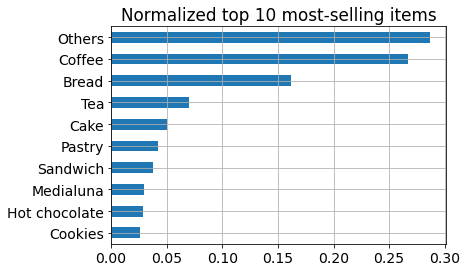

In [157]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

fig = df['Item'].value_counts(normalize=True).sort_values().to_frame().plot(kind='barh',
                                                              title='Normalized top 10 most-selling items',
                                                             grid=True, legend=False)

There are two *extreme solutions* to this problem:
1. We stop buying items in `Others` and give relevant substitutes to our customer from our top 10 items
2. We maximize our customers' satisfaction by keep buying all items in `Others`

However, as you can guess, these two solutions are not the best solution. We need to optimize between these options.

One way to optimize is by looking at another items in `Others`. For example, take 4 items then consider *their expiration time and adequacy of substitution* from the top 9 items

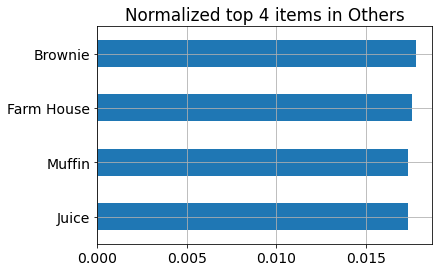

In [158]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

other.head(4).div(sums).to_frame().plot(kind='barh', title='Normalized top 4 items in Others', grid=True, legend=False)
plt.gca().invert_yaxis()

For example, let us look at our top 4 items in `Others`:

1. `Brownie`: according to [this source](https://www.marthastewart.com/264302/tips-for-perfect-brownies),

> Store cut brownie squares in an airtight container at room temperature; they're best eaten within 1 to 2 days.

Thus, it might be not economical to stock `Brownie`, especially because they are *sold less than 2% of the time*. Another strategy is to stock freshly baked `Brownie` everyday and give it a discount after rush hours end (see **Analysis 4.4.**)


2. `Farm House`: according to [this source](https://www.bloomberg.com/profile/company/0294374D:LN),

> Cornish Farmhouse Frozen Foods Ltd was founded in 1974. The company's line of business includes the wholesale distribution of packaged quick-frozen vegetables, juices, meats, fish, and other deep freeze products.

Frozen foods are known to have long expiration date. And so, though the demand was quite low, it is okay to keep `Farm House` food in stock just in case.


3. `Muffin`: according to [this source](https://www.stilltasty.com/fooditems/index/17741),

> Properly stored, freshly baked muffins will last for about 1 to 2 days at normal room temperature.

Thus, it might be better if we can substitute the demand for `Muffin` to other items. Luckily, `Cookie` or `Brownie` can be a good substitute for `Muffin`. Therefore, we can discontinue `Muffin` from the store without losing too many customers.

4. `Juice`: We know that `Farm House` distributes packages of frozen juices. Most fruits can go bad quickly so it is better if we substitute `Juice` by using `Farm House` frozen juices.

We can continue this analysis for more items in `Others` if we want to

### 4.2. Business plan from knowing trend of total transaction overtime

Our number of transactions per day is shown below.

We can see that *there are no significant increases nor decreases* in the number of transactions. Since we only have less than 6 months of data, it is also unclear whether these systematic ups and downs happen due to season or not.

This rather *moderate trend* signifies that our *customers come to our store regularly*, but the *number of customers doesn't increase* either. If this situation happens in our store, it is better to check our marketing methods. It is possible that our **marketing methods were not as effective as it should be and we should focus our resources to reach the market**. For example, we can [develop a first-time customer program](https://www.webstaurantstore.com/article/105/restaurant-marketing.html) to attract new customers.

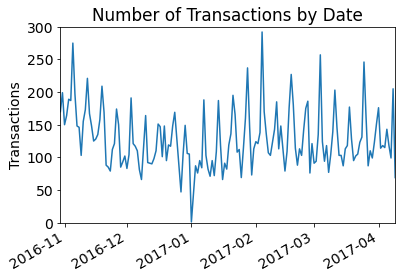

In [165]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

transaction_time_series = df['Date'].value_counts().to_frame().sort_index()
fig = transaction_time_series.plot(kind='line', legend=False, title='Number of Transactions by Date',
                                  ylabel='Transactions')
fig.set_xlim(pd.Timestamp('2016-10-30'), pd.Timestamp('2017-04-09'))
fig.set_ylim(0, 300)
plt.show()

It is easier to look at the trend by *looking only to the weekdays*:

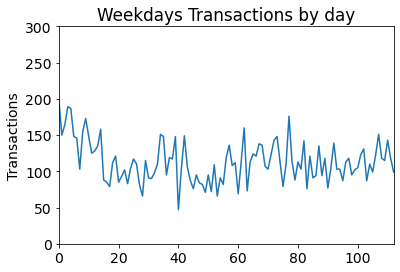

In [166]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

transaction_time_series_weekdays = transaction_time_series [ transaction_time_series.index.dayofweek.isin([0,1,2,3,4]) ]
transaction_time_series_weekdays = transaction_time_series_weekdays.reset_index()
fig = transaction_time_series_weekdays['Date'].plot(kind='line', legend=False, title='Weekdays Transactions by day',
                                  ylabel='Transactions')
fig.set_xlim(0, 112)
fig.set_ylim(0, 300)
plt.show()

### 4.3. Business plan from knowing the comparison of transactions between days in the week

Boxplot of transactions grouped by days is shown below.

We can see that there are no *significant differences between weekdays except for Fridays*. Most likely it happens because Fridays come before weekends and many people spend their money for snacks at Fridays. Therefore, we need to **increase our stock on Fridays compared to other weekdays**.

Weekends are good opportunity to increase our sales because we can see that there are *more transactions per day on Weekends compared to weekdays*. Also, we can see that *Saturdays have the highest average transactions per day* of all. However, we need to take account of the spread for a particular day. For example, although Saturdays have the highest average sales per day, *Saturdays also have the widest spread for transactions per day* of all. **These spread may cause our transactions prediction to be inaccurate and some items left unpurchased**.

There are, again, two extreme approaches to this problem:
1. *Cautious approach*: we make a safer choice by **setting items equal to the median**
2. *Risk taker approach*: we take risks by producing items **more than the median sales by adding a fraction of spread** (measured by interquartile range) on that specific day

Since our bakery will be doing some marketing from now on (from previous **Analysis 4.2.**), it is **generally better to take some risk**.

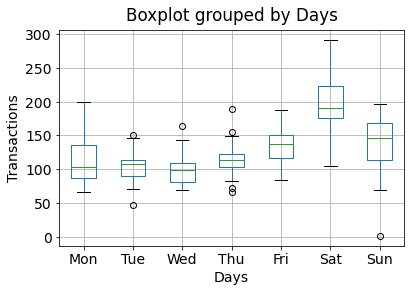

In [167]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

transaction_time_series['Days'] = transaction_time_series.index.dayofweek
transaction_per_day = transaction_time_series.set_index('Days')
transaction_per_day = transaction_per_day.rename(columns={'Date':'Transaction'})
transaction_per_day = transaction_per_day.reset_index()
fig = transaction_per_day.boxplot(by='Days', column=['Transaction'])
plt.title('')
plt.xticks([1,2,3,4,5,6,7], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Transactions')
plt.show()

### 4.4. Business plan from knowing the busiest hours in the bakery

Histogram of transactions grouped by time of the day is shown below.

We can see that most transactions happen between 7 a.m. to 5 p.m. Also, there are few transactions happen after 7 p.m. From this information, we can optimize our work hours. For example, we can **close our store earlier at around 7 p.m. without losing too many customers**.

I also mentioned about giving discounts after rush hours in **Analysis 4.1.** From knowing the transaction hours, we can give discounts to items with shorter expiration dates after the rush hours. It is important to *avoid giving discounts in rush hours* because we might lose some revenue. In this case, we can try **putting discounts for short-lived items** (e.g. `Bread`, `Pastry`, `Brownie`) **after 5 p.m**. This way, we can also attract another type of customers (the *discount hunters*) that usually don't buy items in our store.

Lastly, it is important to know that the peak of rush hours happen in around 11 a.m. If our marketing plan from **Analysis 4.2.** succeed, **it is possible that situation in the store around 11 a.m. gets very busy and we might need to hire part-time staffs from 11 a.m. to 3 p.m.**

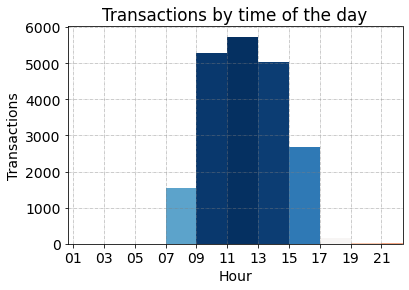

In [168]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

import matplotlib.colors as colors
import matplotlib.dates as mdates
timehist = pd.to_datetime(df['Time'],format="%H:%M:%S")
fig, ax = plt.subplots(1,1)
#create histogram, get bin position for label
N, bins, patches = ax.hist(timehist, bins = 11, facecolor='blue')
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.RdBu(norm(thisfrac))
    thispatch.set_facecolor(color)
#set xticks at bin edges
plt.xticks(bins)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.8)
plt.xlim(pd.to_datetime(-2208985200, unit='s'), pd.to_datetime(-2208906000, unit='s'))
plt.title('Transactions by time of the day')
plt.ylabel('Transactions')
plt.xlabel('Hour')
plt.show()

### 4.5. Business plan from knowing number of items bought in single transactions

Number of items in one transaction and a more detailed stacked barplot is shown below.

We can see that the most frequent number of items sold in one transaction is one. This is not good for various reasons. The first reason is *we miss the opportunity of getting more revenue from one transaction*, here's why. Generally most people need to eat and drink, so it is quite unusual to buy any food without buying any beverage or vice versa. We can **encourage those people who only buy one item in a transaction to spend more by making food and beverage combination discounts**. That way, we can get more revenue from the same person. However, we need to watch out because *food and beverage combinations are the most popular combination if someone buys two items in one transaction*. We need to manage the amount of discount so we get more revenue in total.

That *food and beverage combination discount will also be effective for the exact same reason*. Since most of our customers who buy more than one item generally buy food and beverage, **our appropriate promotion should make them more happy and hence increases their loyalty to our store**.

We can also see that *only a little fraction of our transaction has more than three items*. Generally this means it is **quite unusual for a family to visit our store**. This insight can be used when we are evaluating and thinking about marketing strategies from **Analysis 4.2.** For example, **we can create packages and discounts for families**. That way, we can increase transactions that have more number of items.

Curiously, for two and three items in one transaction, *combination of beverage and others are unexpectedly high*. We remember that we determined `Others` quite arbitrarily by aggregating non-top 9 items. It is quite easy to include more items before aggregating the remaining items into `Others`. However, we will not pursue it any further for now. Just keep in mind that *we can always include more items in our pre-processing steps*.

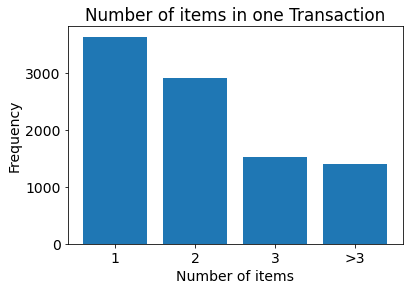

In [169]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

count_transaction = df.groupby(['Transaction']).cumcount() + 1
counts = count_transaction.to_frame().value_counts().to_numpy()

plt.bar(['1','2','3','>3'], [counts[0]-counts[1], counts[1]-counts[2],
                                  counts[2]-counts[3], counts[3]])
plt.title('Number of items in one Transaction')
plt.ylabel('Frequency')
plt.xlabel('Number of items')
plt.show()

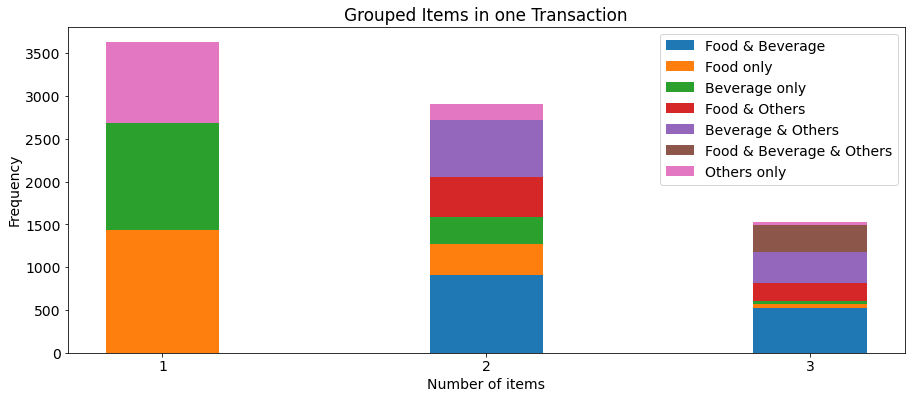

In [170]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

item_map = {'Coffee':3, 'Bread':2, 'Tea':3,
           'Cake':2, 'Pastry':2, 'Sandwich':2,
           'Medialuna':2, 'Hot chocolate':3, 'Cookies':2, 'Others':5}
df['mapped'] = df[['Item']].applymap(item_map.get)
trans_map = df.groupby('Transaction')['mapped'].prod().value_counts()

labels = ['1','2','3']
beverage_only = np.array([trans_map.loc[3], trans_map.loc[9], trans_map.loc[27]])
food_only = np.array([trans_map.loc[2], trans_map.loc[4], trans_map.loc[8]])
food_beverage_mixed = np.array([0, trans_map.loc[6], trans_map.loc[12]+trans_map.loc[18]])
others_only = np.array([trans_map.loc[5], trans_map.loc[25], trans_map.loc[125]])
food_others_mixed = np.array([0, trans_map.loc[10], trans_map.loc[20]+trans_map.loc[50]])
beverage_others_mixed = np.array([0, trans_map.loc[15], trans_map.loc[45]+trans_map.loc[75]])
food_beverage_others = np.array([0, 0, trans_map.loc[30]])
width = 0.35

plt.figure(figsize=(15,6))
plt.bar(labels, food_beverage_mixed, width, label='Food & Beverage')
plt.bar(labels, food_only, width, bottom=food_beverage_mixed, label='Food only')
plt.bar(labels, beverage_only, width, bottom=food_only+food_beverage_mixed, label='Beverage only')
plt.bar(labels, food_others_mixed, width, bottom=food_only+food_beverage_mixed+beverage_only,
        label='Food & Others')
plt.bar(labels, beverage_others_mixed, width, bottom=food_only+food_beverage_mixed+beverage_only+food_others_mixed,
        label='Beverage & Others')
plt.bar(labels, food_beverage_others, width, bottom=food_only+food_beverage_mixed+beverage_only+food_others_mixed+beverage_others_mixed,
        label='Food & Beverage & Others')
plt.bar(labels, others_only, width, bottom=food_beverage_others+food_only+food_beverage_mixed+beverage_only+food_others_mixed+beverage_others_mixed,
        label='Others only')

plt.xlabel('Number of items')
plt.ylabel('Frequency')
plt.title('Grouped Items in one Transaction')
plt.legend()

plt.show()

### 4.6. Business plan from knowing items that are generally bought together

Let's take a closer look for Food \& Beverage combination when two items are bought at the same time. This is a more detailed view on bottom bar for two items in one transaction from the upper figure.

As expected, `Bread`-`Coffee` *combination is the most frequent combination of all*. However, it's not preferable to give discount to that particular combination since it will reduce our profit. Generally, *it's better to pair our popular products with less popular ones*. For example, we can see in the figure below that `Bread` (our most popular food) can go quite well with `Tea`, while `Coffee` (our most popular beverage) can go quite well with `Cookies`. Therefore, **it is a viable option to give discounts to Bread-Tea and Coffee-Cookies combination**. This way, as mentioned in **Analysis 4.5.**, we hope to *reduce single-item-purchase in one transaction by encouraging them to spend more on discounted combinations* and get more revenue from the customers.

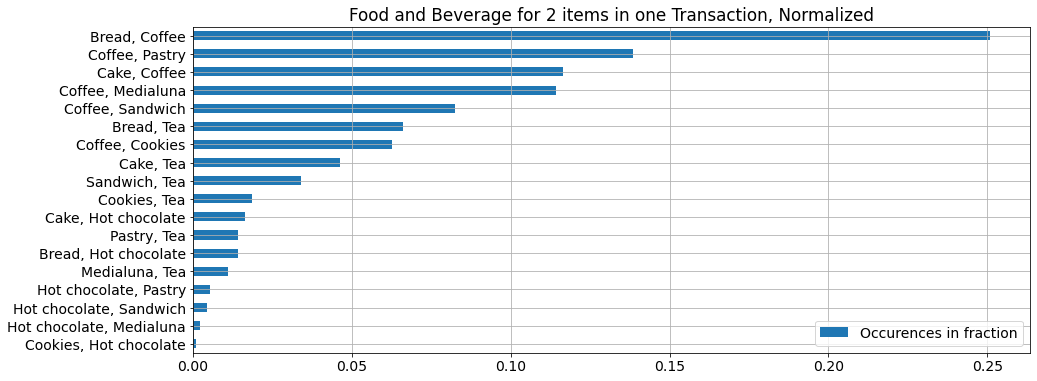

In [171]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

from collections import Counter

group = []
food_beverage_group_pre = []
food_beverage_group = []

groups = df.groupby('Transaction')['Item'].agg(list).to_frame()
for i in groups['Item']:
    member = list(dict.fromkeys(i))
    group.append(member)
    
trans_group = df.groupby('Transaction')['mapped'].prod()
for i in range(len(trans_group)):
    if trans_group.iloc[i] == 6:
        food_beverage_group_pre.append(group[i])

for t in food_beverage_group_pre:
    t.sort()
    food_beverage_group.append(', '.join(map(str, t)))
    
food_beverage_occurence = dict(Counter(food_beverage_group))

del food_beverage_group_pre
del food_beverage_group

food_beverage_occurence = pd.DataFrame.from_dict(food_beverage_occurence, orient='index', columns=['occurence'])
food_beverage_occurence.div(trans_map.loc[6]).sort_values('occurence').plot(kind='barh', figsize=(15,6), grid=True)
plt.title('Food and Beverage for 2 items in one Transaction, Normalized')
plt.legend(['Occurences in fraction'], loc='lower right')
plt.show()

## 5. Conclusion

By analyzing the dataset, we conclude that the *best business plans* for this bakery are:
1. We focus on keeping top 9 best-selling products and products with longer lifespan. Items that have shorter lifespan will be discounted after rush hours at 5 p.m.
2. We will evaluate and generate new marketing plan to attract more segments of customers. One possible marketing strategy is to implement first-time customer program.
3. We need to prepare more items on Fridays, Sundays, and especially Saturdays. Also, It is better to go with risk-taker approach by preparing more items in the store every day, since we are going to do some serious marketing from now on.
4. We need to prepare for rush hours from 7 a.m. to 5 p.m., especially 9 a.m. to 3 p.m.
5. We can optimize our bakery sales by making Food \& Beverage dicounts, e.g. for Bread-Tea and Coffee-Cookies combination. Also, we should consider making family packages and discounts.